# Explicit formula (Theorem 1)

In [1]:
def tau(h, k):
    return (h + 1)*(2*k + 1)/2

@cached_function
def p(n, h=None):
    if h is None:
        return sum(p(n, h) for h in range(n+1))
    else:
        if n == 0:
            return ZZ(h == 0)
        m = (n+1)/2
        return 4^(1-m) * sum((-1)^k * tau(h,k)/m * binomial(2*m, m - tau(h,k)) 
                             if mod(h+1-2*m, 2) == 0 else 0 for k in range(2*m+1))

In [2]:
[p(n) for n in range(10)]

[1, 1, 1/2, 3/4, 1/2, 9/16, 15/32, 29/64, 55/128, 25/64]

In [3]:
# check that Theorem 1 yields the same results as Proposition 2.2 for small parameters.
all([p(n, h) == (2/chebyshev_T(h+1, 1/x)).series(x, n+2).coefficient(x^(n+1))
     for n in range(1, 30) for h in range(30)])

True

In [4]:
prob = [p(n) for n in range(101)]

In [5]:
prob_exp = [sum(p(n, h) * h for h in range(n+1))/prob[n] for n in range(101)]

In [6]:
prob_var = [sum(h^2 * p(n, h) for h in range(n+1))/prob[n] - prob_exp[n]^2 for n in range(101)]

# Shifted central binomial coefficient (series $S(\alpha, n)$, Lemma 3.1)

In [7]:
R.<M> = LaurentSeriesRing(QQ, default_prec=20)
R2.<a> = LaurentSeriesRing(R, default_prec=20)

def stirling_coef(k): # due to G. Nemes, http://arxiv.org/abs/1003.2907
    return factorial(2*k)/(2^k * factorial(k)) \
            * sum(binomial(k + i - 1/2, i) * binomial(3*k + 1/2, 2*k - i)*2^i * 
                sum(binomial(i,j) * (-1)^j * factorial(j) * 
                    stirling_number2(2*k + i + j,j)/factorial(2*k + i + j) 
                    for j in range(i + 1)) for i in range(2*k + 1))
    
def truncate_inner(expr, r):
    coefs = expr.coefficients()
    expos = expr.exponents()
    for j in range(len(coefs)):
        coefs[j] = coefs[j].truncate_neg(-expos[j] - r)
    return sum(a^expos[j] * coefs[j] for j in range(len(coefs)))

def S(a, M, prec=20):
    return (sum(stirling_coef(r) * (2*M)^-r for r in range(prec)) *
            sum((-1)^r * stirling_coef(r) * (M + a)^-r for r in range(prec)).truncate(prec) * 
            sum((-1)^r * stirling_coef(r) * (M - a)^-r for r in range(prec)).truncate(prec) * 
            sum((-1)^r * binomial(-1/2, r) * (a/M)^(2*r) for r in range(prec)).truncate(prec) * 
            sum(1/factorial(r) * a^(4*r)/M^(3*r) * 
                (sum(-1/((t + 2)*(2*t + 3)) * (a/M)^(2*t) for t in range(prec))^r).truncate(prec) 
                for r in range(prec))).truncate(prec)

# Mellin translation (Lemma 3.2)

In [8]:
var('m')

m

In [9]:
dirichlet_beta = {1:pi/4, 2:catalan, 3:pi^3/32} # particular values of the Dirichlet beta function

def mellin_translation(expr, r): # specify the factor (h+1)^r, cf. (10)
    coefs = expr.coefficients()
    expos = expr.exponents()
    erg = 0
    for k in range(len(coefs)):
        j = (expos[k] - 1)/2
        erg = erg + (2^(r-1) * gamma(j+1+r/2) * 
                     dirichlet_beta[r+1] * m^(j+1) * sqrt(m)^r) * coefs[k].subs(M=m)
    return expand(erg)

# Computing the asymptotic expansions (Theorem 2)

## Probabilities $p_n$ (cf. (9)):

In [10]:
var('m n')

(m, n)

In [11]:
asy_prob = (4/(sqrt(pi)*sqrt(m)) * mellin_translation(truncate_inner(S(a,M,15), 15) * a/M, 0)).subs(m = (n+1)/2)

In [12]:
asy_prob = expand(asy_prob).taylor(n, oo, 10); asy_prob

1/2*sqrt(2)*sqrt(pi)/sqrt(n) - 5/24*sqrt(2)*sqrt(pi)/n^(3/2) + 127/960*sqrt(2)*sqrt(pi)/n^(5/2) - 1571/16128*sqrt(2)*sqrt(pi)/n^(7/2) - 1896913/184320*sqrt(2)*sqrt(pi)/n^(9/2) + 3716111711/4866048*sqrt(2)*sqrt(pi)/n^(11/2) - 456593290865603/29520691200*sqrt(2)*sqrt(pi)/n^(13/2) + 184340777593171739/1062744883200*sqrt(2)*sqrt(pi)/n^(15/2) - 43935089397922667677/34007836262400*sqrt(2)*sqrt(pi)/n^(17/2) + 1279993678995557741521/190443883069440*sqrt(2)*sqrt(pi)/n^(19/2)

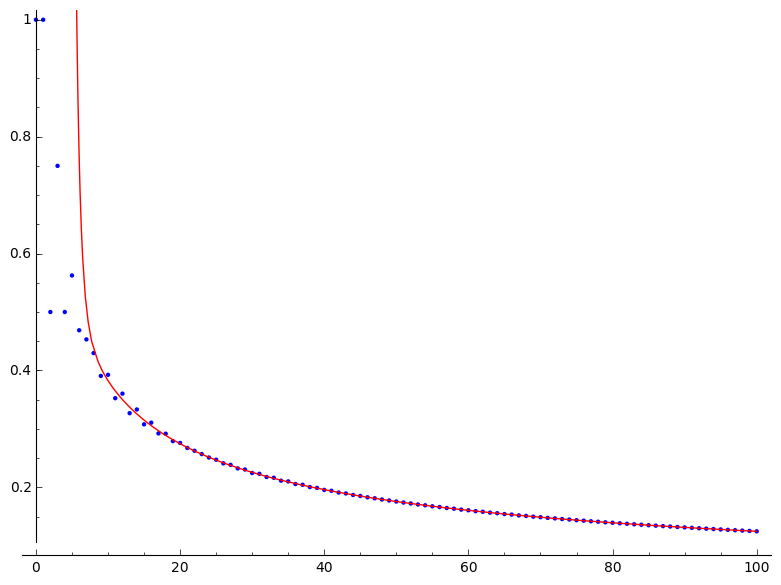

In [13]:
P = plot(asy_prob, n, 0.5, 100, ymax=1, color='red') + list_plot(prob); P

## Expected value $\mathbb{E} H_n$:

In [14]:
var('m n')

(m, n)

In [15]:
asy_exp = (4/(sqrt(pi)*sqrt(m))
           *mellin_translation(truncate_inner(S(a,M,15), 15)*a/M, 1)).subs(m=(n + 1)/2)/asy_prob - 1

In [16]:
asy_exp.taylor(n, oo, 10)

2*sqrt(2)*catalan*sqrt(n)/sqrt(pi) + 5/6*sqrt(2)*catalan/(sqrt(pi)*sqrt(n)) - 131/720*sqrt(2)*catalan/(sqrt(pi)*n^(3/2)) + 1129/12096*sqrt(2)*catalan/(sqrt(pi)*n^(5/2)) - 88061611/907200*sqrt(2)*catalan/(sqrt(pi)*n^(7/2)) + 65631622327/9580032*sqrt(2)*catalan/(sqrt(pi)*n^(9/2)) - 172247261860077449/1307674368000*sqrt(2)*catalan/(sqrt(pi)*n^(11/2)) + 4399396764901604611/3138418483200*sqrt(2)*catalan/(sqrt(pi)*n^(13/2)) - 94737237358744207421/9607403520000*sqrt(2)*catalan/(sqrt(pi)*n^(15/2)) + 1823358518956368024133/38023147008000*sqrt(2)*catalan/(sqrt(pi)*n^(17/2)) - 3503171213907812001746827472407/13362733110421094400000*sqrt(2)*catalan/(sqrt(pi)*n^(19/2)) - 1

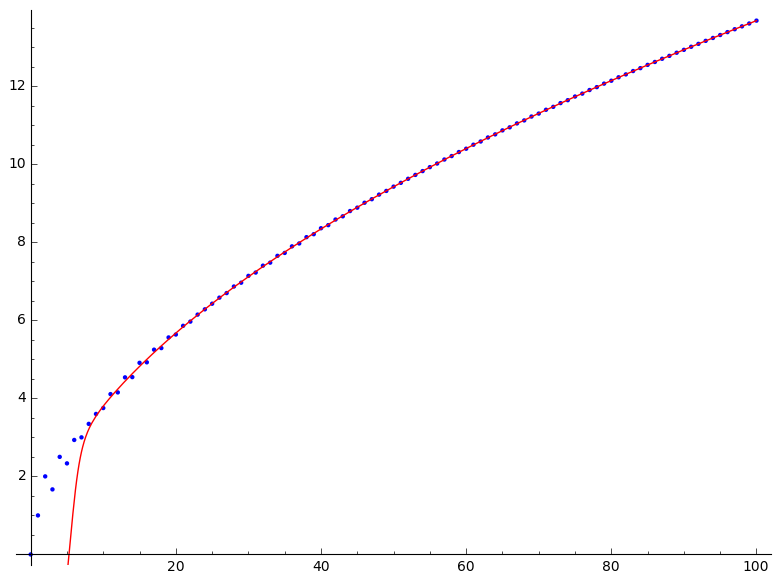

In [17]:
P = plot(asy_exp, n, 0.5, 100, color='red', ymin=0) + list_plot(prob_exp); P

## Variance $\mathbb{V} H_n$:

In [18]:
var('m n')

(m, n)

In [19]:
asy_var = (4/(sqrt(pi)*sqrt(m)) * 
           mellin_translation(truncate_inner(S(a,M,15), 15) * a/M, 2))\
            .subs(m=(n + 1)/2)/asy_prob - (asy_exp + 1)^2

In [20]:
asy_var.taylor(n, oo, 3)

1/4*(pi^3 - 32*catalan^2)*n/pi + 1/6*(pi^3 - 40*catalan^2)/pi - 1/180*(pi^3 - 12*catalan^2)/(pi*n) + 1/1890*(11*pi^3 - 265*catalan^2)/(pi*n^2) - 1/1814400*(75273088*pi^3 - 1408301149*catalan^2)/(pi*n^3)

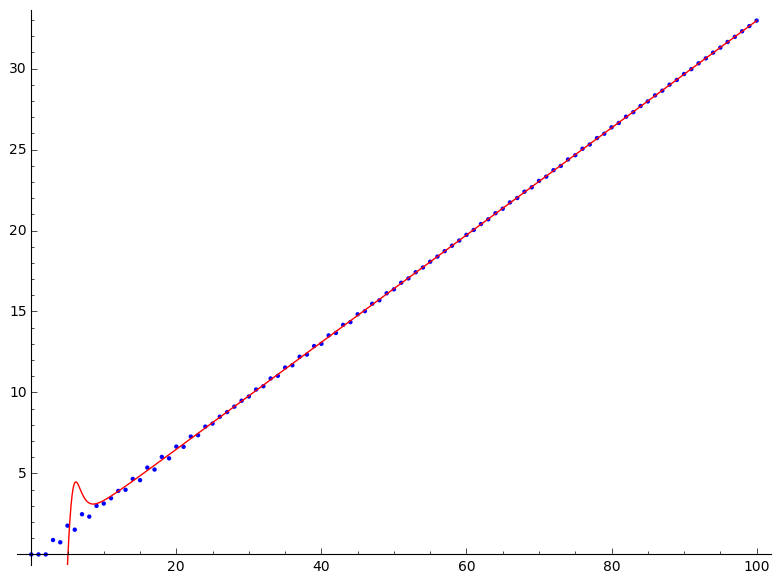

In [21]:
P = plot(asy_var, n, 0.5, 100, color='red', ymin=0) + list_plot(prob_var); P